In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [275]:
df = pd.read_csv('grocery_dataset_eda.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df[(df.index >= '2018-01-01') & (df.index <= '2025-01-31')]

In [276]:
# Count total missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Series([], dtype: int64)

In [277]:
# Count infs
inf_counts = df.isin([np.inf, -np.inf]).sum()
inf_counts = inf_counts[inf_counts>0]
inf_counts

Series([], dtype: int64)

In [278]:
df['grocery_sales_lag1']

date
2018-01-31    55885.0
2018-02-28    55336.0
2018-03-31    55555.0
2018-04-30    55716.0
2018-05-31    55859.0
               ...   
2024-09-30    74559.0
2024-10-31    75140.0
2024-11-30    75403.0
2024-12-31    75235.0
2025-01-31    76036.0
Name: grocery_sales_lag1, Length: 85, dtype: float64

### Forecast ###

In [279]:
# Define independent (X) and dependent (y) variables
X = df[['grocery_sales_lag1', 'cpi_fah', 'home_price', 'rdi', 'covid1', 'covid2']]
y = df['grocery_sales']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit OLS (Ordinary Least Squares) regression model
model_sm = sm.OLS(y, X).fit()

# Print detailed statistical summary
print(model_sm.summary())

# merge fitted values onto dh.  We don't need to merge because the row indices are the same
df['forecasted'] = model_sm.fittedvalues
df['residuals'] = model_sm.resid

                            OLS Regression Results                            
Dep. Variable:          grocery_sales   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2682.
Date:                Sun, 02 Mar 2025   Prob (F-statistic):           3.65e-88
Time:                        17:51:39   Log-Likelihood:                -647.54
No. Observations:                  85   AIC:                             1309.
Df Residuals:                      78   BIC:                             1326.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                469.1866   1545

In [280]:
# All stored in sm_model behind the scenes
print(dir(model_sm))

['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abat_diagonal', '_cache', '_data_attr', '_data_in_cache', '_get_robustcov_results', '_get_wald_nonlinear', '_is_nested', '_transform_predict_exog', '_use_t', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'diagn', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'info_crit

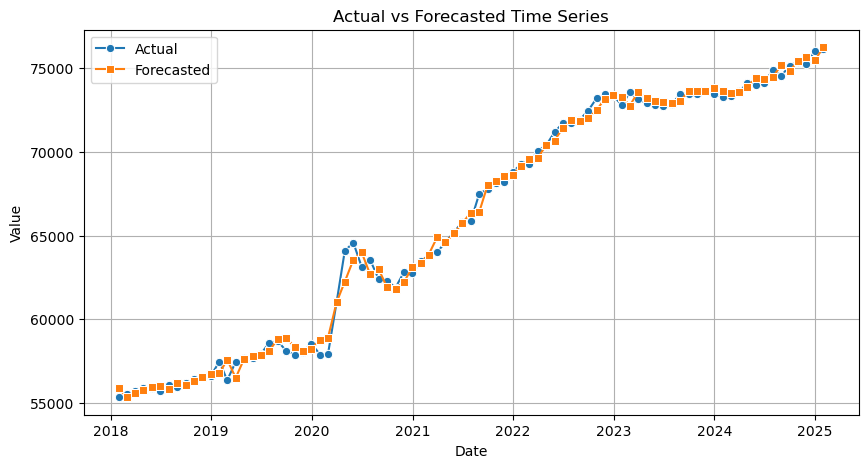

In [281]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x=df.index, y='grocery_sales', label='Actual', marker='o')
sns.lineplot(data=df, x=df.index, y='forecasted', label='Forecasted', marker='s')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted Time Series')
plt.legend()
plt.grid(True)

plt.show()


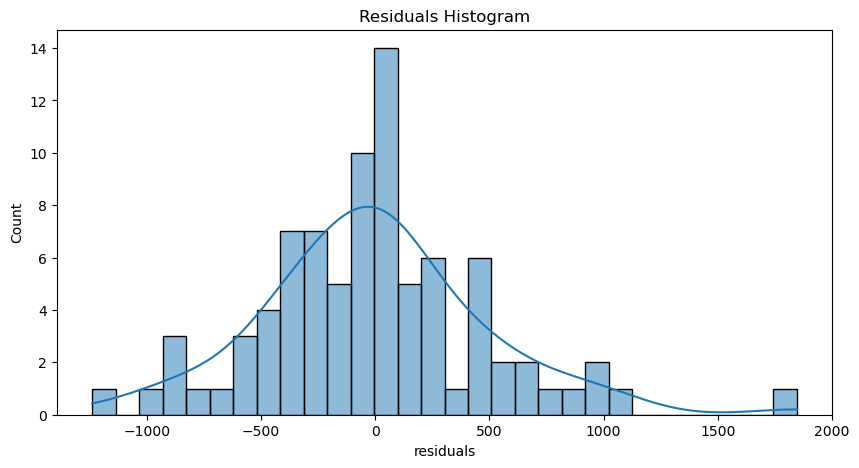

In [282]:
plt.figure(figsize=(10, 5))
sns.histplot(df["residuals"], bins=30, kde=True)
plt.title('Residuals Histogram')
plt.show()

<Figure size 1000x500 with 0 Axes>

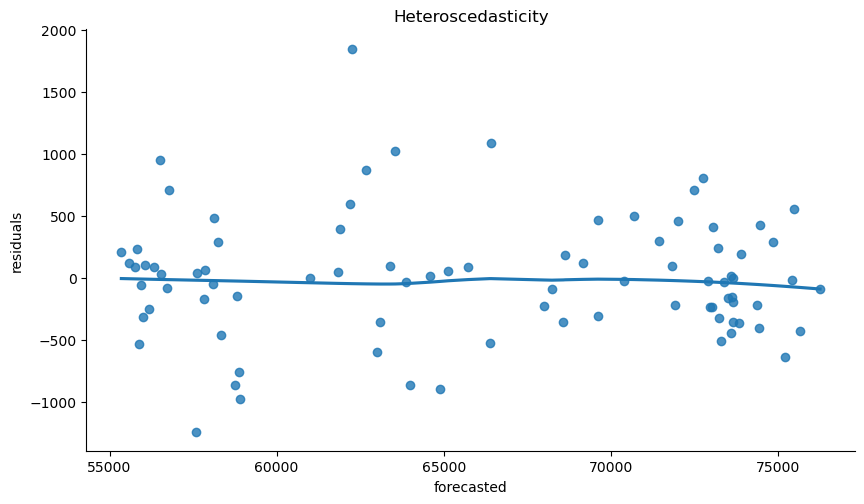

In [283]:
plt.figure(figsize=(10, 5))
sns.lmplot(x="forecasted", y="residuals", data=df, lowess=True, aspect=1.75, height=5)
plt.title('Heteroscedasticity')
plt.show()

In [284]:
# Step 1: Add a constant column (intercept)
X = sm.add_constant(X)

# Step 2: Initialize an empty list to store VIF values
vif_list = []

# Step 3: Loop through each feature and compute VIF
for i in range(X.shape[1]):  # Loop over each column index
    vif_value = variance_inflation_factor(X.values, i)  # Compute VIF for the column
    vif_list.append((X.columns[i], vif_value))  # Store (Feature Name, VIF Value)

# Step 4: Convert results into a DataFrame
vif_data = pd.DataFrame(vif_list, columns=["Feature", "VIF"])
vif_data

Feature           VIF
0               const  7.683861e+02
1  grocery_sales_lag1  6.339868e+01
2             cpi_fah  1.361328e+06
3          home_price  8.216028e+05
4                 rdi  6.231016e+01
5              covid1  7.137975e+08
6              covid2  6.765430e+08

In [285]:
# Ensure X includes the same predictors used in training

# Get predictions and confidence intervals
predictions = model_sm.get_prediction(X)
pred_summary = predictions.summary_frame(alpha=0.05)  # 95% CI

# Store forecasted values
df['forecasted'] = pred_summary['mean']  # Mean prediction
df['se_mean'] = pred_summary['mean_se']  # SE of the mean

# ✅ Corrected: Use 'obs_ci_lower' & 'obs_ci_upper' for observation CI
df['lower_bound_obs'] = pred_summary['obs_ci_lower']
df['upper_bound_obs'] = pred_summary['obs_ci_upper']

# ✅ Compute SE of the estimate (obs_se) using the correct columns
df['se_obs'] = (df['upper_bound_obs'] - df['lower_bound_obs']) / (2 * 1.96)  # 95% CI

# ✅ Store mean confidence interval bounds
df['lower_bound'] = pred_summary['mean_ci_lower']
df['upper_bound'] = pred_summary['mean_ci_upper']

# Show first few rows
df[['forecasted', 'se_mean', 'se_obs', 'lower_bound', 'upper_bound', 'lower_bound_obs', 'upper_bound_obs']].head()

forecasted     se_mean      se_obs   lower_bound   upper_bound  \
date                                                                           
2018-01-31  55866.229933  125.840917  537.473621  55615.699913  56116.759954   
2018-02-28  55350.922945  127.161378  537.794172  55097.764089  55604.081801   
2018-03-31  55593.831695  121.621294  536.470474  55351.702298  55835.961092   
2018-04-30  55772.141445  119.969524  536.086614  55533.300469  56010.982421   
2018-05-31  55952.330030  115.227905  535.012393  55722.928894  56181.731166   

            lower_bound_obs  upper_bound_obs  
date                                          
2018-01-31     54812.781637     56919.678230  
2018-02-28     54296.846369     56404.999521  
2018-03-31     54542.349566     56645.313824  
2018-04-30     54721.411682     56822.871208  
2018-05-31     54903.705739     57000.954321

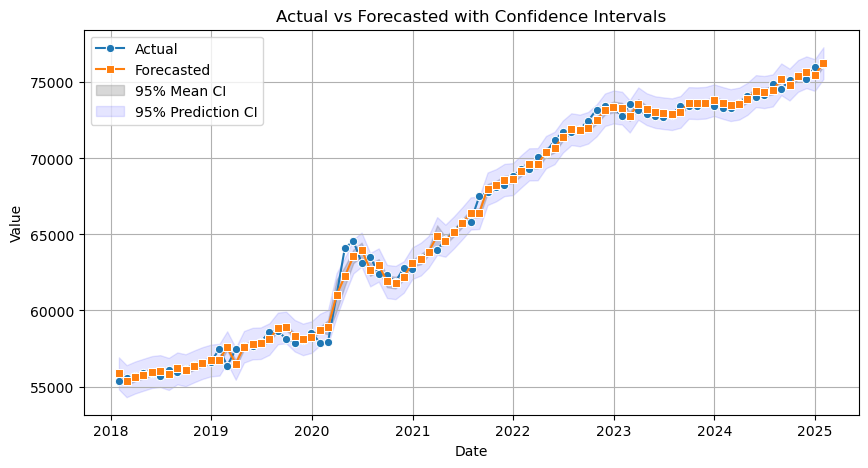

In [286]:
# Define the start and end date for filtering
#start_date = '2021-01-01'
#end_date = '2024-12-31'

# Filter the DataFrame to only include the desired months
#df_subset = df.loc[start_date:end_date]
#df_subset

#Plot the chart
plt.figure(figsize=(10, 5))

sns.lineplot(data=df, x=df.index, y=df['grocery_sales'], label='Actual', marker='o')
sns.lineplot(data=df, x=df.index, y='forecasted', label='Forecasted', marker='s')

plt.fill_between(df.index, df['lower_bound'], df['upper_bound'], color='gray', alpha=0.3, label="95% Mean CI")
plt.fill_between(df.index, df['lower_bound_obs'], df['upper_bound_obs'], color='blue', alpha=0.1, label="95% Prediction CI")

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecasted with Confidence Intervals')
plt.legend()
plt.grid(True)

plt.show()


### Forward Forecast ###

In [287]:
# Define monthly growth rates
cpi_growth_rate = 1.016  # 1.6% monthly increase
home_price_growth_rate = 1.02  # 2% monthly increase

# Define forecast period (Feb - Dec)
future_dates = pd.date_range(start="2024-02-01", end="2024-12-01", freq='MS')

# Create a DataFrame for projections
df_future = pd.DataFrame(index=future_dates)


In [288]:
# Get the last known forecasted grocery sales value
last_sales_value = df['forecasted'].iloc[-1]  # Last available forecasted sales
last_cpi_fah = df['cpi_fah'].iloc[-1]  # Last known CPI-FAH value
last_home_price = df['home_price'].iloc[-1]  # Last known home price

In [289]:
# Generate forecast periods (Feb to Dec)
forecast_periods = np.arange(1, len(df_future) + 1)  # Convert to a NumPy array

# Correct the exponential growth calculation
df_future['cpi_fah'] = last_cpi_fah * (cpi_growth_rate ** forecast_periods)
df_future['home_price'] = last_home_price * (home_price_growth_rate ** forecast_periods)